This code creates the capytaine mesh by creating the water-facing outline of each region, creating a mask that says whether the panels associated with each region are heaving or not, then adding the region meshes together before adding the dof with the mask. The code generated capytaine data for a variety of configurations and over a range of wavenumbers (plotted in meem-vs-capytaine data).

Pros: More arbitrary configurations, no excess panels.

Cons: Making the theta direction panel density different between regions will create gaps. This does not appear to change the results for reasonably high resolutions.

In [2]:
# This generates configuration values with Capytaine.

#!pip install capytaine #uncomment if first time running

import capytaine as cpt
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time

# removes capytaine warnings from clogging outputs
import logging
logging.getLogger("capytaine").setLevel(logging.ERROR)

In [3]:
def save_potential_array(title, arr):
    file_path = title + "-real" + ".csv"
    np.savetxt(file_path, np.real(arr), delimiter=",", fmt="%.6e")
    file_path = title + "-imag" + ".csv"
    np.savetxt(file_path, np.imag(arr), delimiter=",", fmt="%.6e")

# use to get rid of prints
def deafen(function, *args):
    real_stdout = sys.stdout
    sys.stdout = open(os.devnull, "w")
    output = function(*args)
    sys.stdout = real_stdout
    return output

In [4]:
solver = cpt.BEMSolver()

def timed_solve(problem, reps):
    t_lst = []
    for i in range(reps):
        t0 = time.perf_counter()
        result = solver.solve(problem, keep_details = True)
        t1 = time.perf_counter()
        t_lst.append(t1 - t0)
    tdiff = sum(t_lst)/reps
    return result, tdiff

def get_points(a, d): # These points define the outline of the body
    d_prime = d + [0]
    d_index = 0
    a_index = 0
    pt_lst = [(0, - d[0])]
    for i in range(len(a)):
        pt_lst.append((a[a_index], - d_prime[d_index]))
        d_index +=1
        pt_lst.append((a[a_index], - d_prime[d_index]))
        a_index+=1
    return pt_lst

# compute number of panels along each surface given total number along the outline
def get_f_densities(pt_lst, total_units):
    face_lengths = np.array([])
    for i in range(len(pt_lst) - 1):
        p1, p2 = pt_lst[i], pt_lst[i + 1]
        face_length = abs(p2[0] - p1[0]) + abs(p2[1] - p1[1]) # one of these two values will be zero
        face_lengths = np.append(face_lengths, face_length)
    total_length = sum(face_lengths)
    each_face_densities = np.vectorize(lambda x: max(1, x/total_length * total_units))(face_lengths) # each face needs at least one panel
    remainders = each_face_densities % 1
    each_face_densities = each_face_densities.astype(int)
    remaining_units = total_units - sum(each_face_densities)
    if remaining_units < 0: # high proportion of small faces
        for u in range(remaining_units * -1):
            i = np.argmax(each_face_densities) # cut density from the largest faces
            each_face_densities[i] = (each_face_densities[i]) - 1
    else:
        for u in range(remaining_units): # distribute remaining units where most needed
            i = np.argmax(remainders)
            each_face_densities[i] = (each_face_densities[i]) + 1
            remainders[i] = 0
    assert sum(each_face_densities) == total_units
    return each_face_densities
    
def make_face(p1, p2, f_density, t_density):
    zarr = np.linspace(p1[1], p2[1], f_density + 1)
    rarr = np.linspace(p1[0], p2[0], f_density + 1)
    xyz = np.array([np.array([x/np.sqrt(2),y/np.sqrt(2),z]) for x,y,z in zip(rarr,rarr,zarr)])
    return cpt.AxialSymmetricMesh.from_profile(xyz, nphi = t_density)

def faces_and_heaves(heaving, region, p1, p2, f_density, t_density, meshes, mask, panel_ct):
    mesh = make_face(p1, p2, f_density, t_density)
    meshes += mesh
    new_panels = f_density * t_density
    if heaving[region]:
        direction = [0, 0, 1]
    else:
        direction = [0, 0, 0]
    for i in range(new_panels):
        mask.append(direction)
    return meshes, mask, (panel_ct + new_panels)

def get_excitation_phase(result):
    return np.angle((cpt.assemble_dataset([result]))["excitation_force"][0][0][0])

def make_body(pts, t_densities, f_densities, heaving):
    meshes = cpt.meshes.meshes.Mesh()
    panel_ct = 0
    mask = []
    for i in range((len(pts) - 1) // 2):
        p1, p2, p3 = pts[2 * i], pts[2 * i + 1], pts[2 * i + 2]
        # make a horizontal face
        meshes, mask, panel_ct = faces_and_heaves(heaving, i, p1, p2, f_densities[2 * i], t_densities[i], meshes, mask, panel_ct)
        # make a vertical face
        if p2[1] < p3[1]: # body on left
            region = i
        else: # body on right
            region = i + 1
        meshes, mask, panel_ct = faces_and_heaves(heaving, region, p2, p3, f_densities[2 * i + 1], t_densities[region], meshes, mask, panel_ct)
    body = deafen(cpt.FloatingBody, meshes) # unclosed boundary warnings
    return body, panel_ct, mask

###################################
# Solving
def rb_solve(a, d, heaving, t_densities, face_units, m0, h, rho, reps):
    pt_lst = get_points(a, d)
    f_densities = get_f_densities(pt_lst, face_units)
    
    body, panel_count, mask = make_body(pt_lst, t_densities, f_densities, heaving)
    body.dofs["Heave"] = mask  
    # body.show_matplotlib() # uncomment to show mesh
    
    rad_problem = cpt.RadiationProblem(body = body, wavenumber = m0, water_depth = h, rho = rho)
    result, t_diff = timed_solve(rad_problem, reps)

    diff_problem = cpt.DiffractionProblem(body = body, wavenumber = m0, water_depth = h, rho = rho)
    result_d, t_diff_d = timed_solve(diff_problem, reps)

    g = 9.81
    omega = np.sqrt(m0*np.tanh(m0*h)*g)

    am = np.array(list(result.added_mass.values()))
    dp = np.array(list(result.radiation_damping.values()))
    am_nondim = h**3 / (rho * np.pi * max(a)**3) * am
    dp_nondim = h**3 / (omega * rho * np.pi * max(a)**3) * dp

    #print("Panel Count: ", panel_count)
    #print(result.added_mass)
    #print(result.radiation_damping)
    #print("Solve Time (Radiation): ", t_diff)
    #print("Solve Time (Diffraction): ", t_diff_d)
    #print("Excitation Phase: ", get_excitation_phase(result_d))
    return am, dp, am_nondim, dp_nondim

In [5]:
# # Mini Bicylinder
# h = 1.001
# d = [0.25, 0.125]
# a = [0.125, 0.25]
# heaving = [1, 1]

# # Small Bicylinder
# h = 1.001
# d = [0.5, 0.25]
# a = [0.5, 1.0]
# heaving = [1, 1]

# # Big Bicylinder
# h = 1.001
# d = [0.75, 0.5]
# a = [0.5, 0.75]
# heaving = [1, 1]

# # Mini Tricylinder
# h = 2.001
# d = [1.0, 0.5, 0.25]
# a = [0.25, 0.5, 1.0]
# heaving =[1, 1, 1]

# Small Tricylinder
h = 20.0
d = [15, 10, 5]
a = [5, 10, 15]
heaving =[1, 1, 1]

# # Big Tricylinder
# h = 25.0
# d = [20, 15, 10]
# a = [10, 15, 20]
# heaving =[1, 1, 1]

# # Some Bicylinder
# h = 1.001
# d = [0.75, 0.25]
# a = [0.25, 0.75]
# heaving = [1, 1]

t_densities = [50, 50, 50] # number of panels around each cylinder
face_units = 50 # number of panels along the outline of the configuration
m0 = 1
rho = 1023 # density of our special material
config = "config0"

m0_nums = np.concatenate((np.linspace(0.1, 1, 20), np.linspace(1, 6, 30)))

results = [rb_solve(a, d, heaving, t_densities, face_units, m0, h, rho, 1) for m0 in m0_nums]
# results = rb_solve(a, d, heaving, t_densities, face_units, m0, h, rho)

hydro_collector_real_CPT = [res[2].flatten() for res in results]
hydro_collector_imag_CPT = [res[3].flatten() for res in results]

# plt.figure()
# plt.plot(m0_nums,A_nondim, m0_nums,B_nondim, '*-')
# plt.xlabel("Wavenumber m0")
# plt.ylabel("Added mass (kg)")
# plt.show()



/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_29770/894598877.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


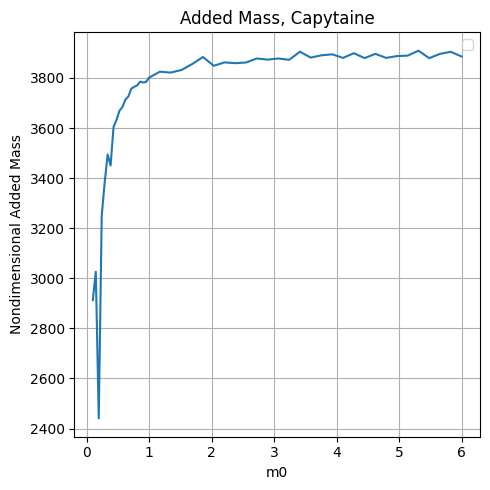

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_29770/894598877.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


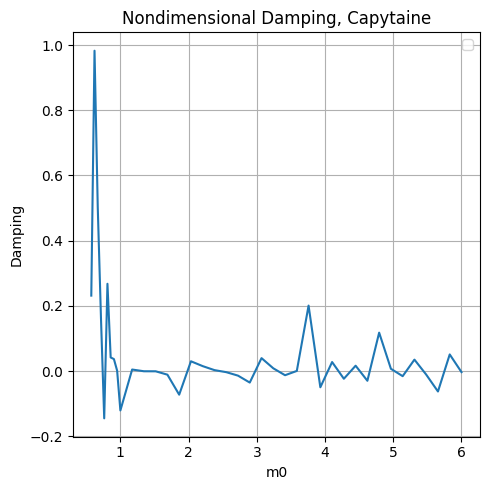

In [ ]:
# Create the plots
plt.figure(figsize=(5,5))
plt.plot(m0_nums, hydro_collector_real_CPT, linestyle='-')
plt.title('Added Mass, Capytaine')
plt.xlabel('m0')
plt.ylabel('Nondimensional Added Mass')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.plot(m0_nums[10:], hydro_collector_imag_CPT[10:], linestyle='-') 
plt.title('Nondimensional Damping, Capytaine')
plt.xlabel('m0')
plt.ylabel('Damping')
plt.grid(True)
plt.tight_layout()
plt.show()

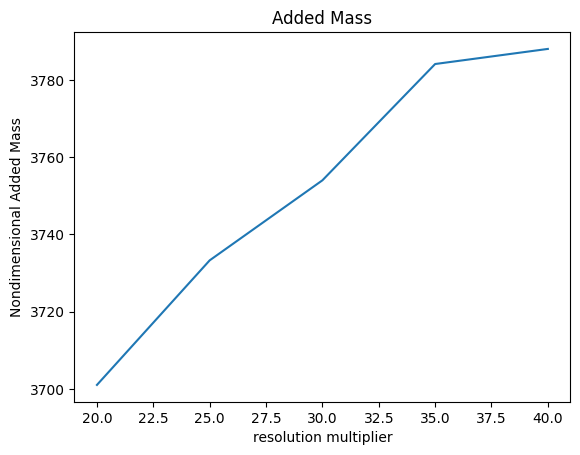

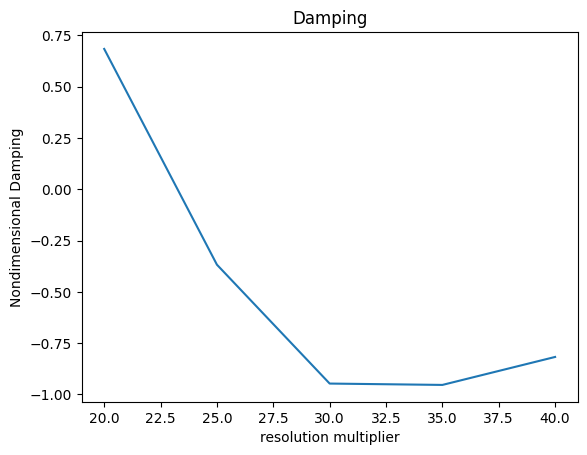

In [7]:
panel_mult = [20, 25, 30, 35, 40]
t_densities = [1, 1, 1] # number of panels around each cylinder
face_units = 1 # number of panels along the outline of the configuration
results = [rb_solve(a, d, heaving, [t * i for t in t_densities] , face_units*i, 1, h, rho, 1) for i in panel_mult]

A_nondim = [res[2].flatten() for res in results]
B_nondim = [res[3].flatten() for res in results]

# plt.plot(panel_mult,A_nondim, panel_mult,B_nondim, '*-')

plt.figure()
plt.plot(panel_mult, A_nondim)
plt.title("Added Mass")
plt.xlabel("resolution multiplier")
plt.ylabel("Nondimensional Added Mass")
plt.show()

plt.figure()
plt.plot(panel_mult, B_nondim)
plt.title("Damping")
plt.xlabel("resolution multiplier")
plt.ylabel("Nondimensional Damping")
plt.show()

In [ ]:
# print(A_nondim)
# print(B_nondim)

# Extract values from NumPy arrays
flat_list1 = [x.item() for x in A_nondim]
flat_list2 = [x.item() for x in B_nondim]

# Convert to MATLAB-style string
matlab_list1 = "pyCapytaine_mu_nondim = [" + " ".join(map(str, flat_list1)) + "];"
matlab_list2 = "pyCapytaine_lambda_nondim = [" + " ".join(map(str, flat_list2)) + "];"

# Print MATLAB-style string
print(matlab_list1)
print(matlab_list2)

# MATLAB used to help generate the .figs

pyCapytaine_mu_nondim = [3701.031582011947 3733.2969738454644 3754.0258594650613 3784.1506994293472 3788.0606409779525];
pyCapytaine_lambda_nondim = [0.6838363667108702 -0.3675180044587952 -0.9468423979028825 -0.9534687146344872 -0.8171612989913569];
